In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Wireline Senior Specialist 1']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                         Queue  Forecasted_AHT  \
0 2021-07-02 10:00:00  Wireline Senior Specialist 1           431.0   
1 2021-07-02 10:15:00  Wireline Senior Specialist 1           430.0   
2 2021-07-02 10:30:00  Wireline Senior Specialist 1           415.0   

   Forecasted_CV  Actual_AHT  Actual_CV  
0           10.0       398.0        9.0  
1            9.0       398.0        8.0  
2           11.0       409.0       10.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 07:00:00        1.0
1 2017-01-02 07:15:00        1.0
2 2017-01-02 07:30:00        3.0

In [4]:
weekly_cv = grouped_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08     1864.0
2017-01-15     1873.0
2017-01-22     1950.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 07:00:00            3.0
1 2017-01-02 07:15:00            3.0
2 2017-01-02 07:30:00            2.0

In [6]:
weekly_fcv = grouped_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08         1717.0
2017-01-15         1693.0
2017-01-22         1794.0

In [7]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds   for_y
293 2022-08-21  2722.0
294 2022-08-28  2670.0
295 2022-09-04     NaN

In [8]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds       y
293 2022-08-21  2596.0
294 2022-08-28  2548.0
295 2022-09-04     NaN

#### Initiate Prophet

In [9]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds         yhat   yhat_lower   yhat_upper
397 2024-08-18  2550.535088  2014.951622  3054.335584
398 2024-08-25  2546.694306  2010.024801  3059.519436
399 2024-09-01  2514.081307  1966.739050  3074.426563

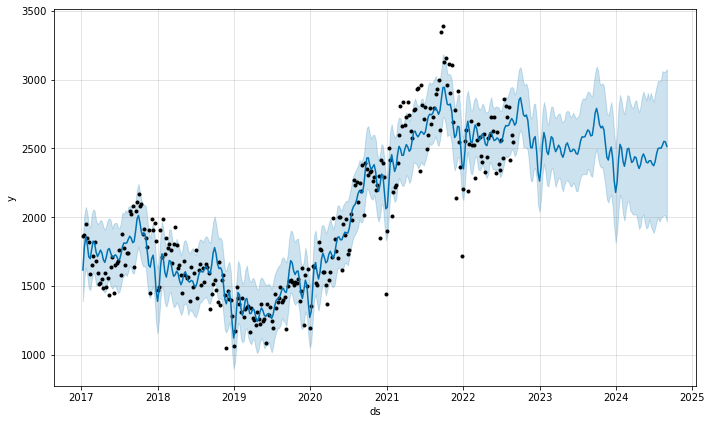

In [12]:
fig1 = m.plot(forecast)

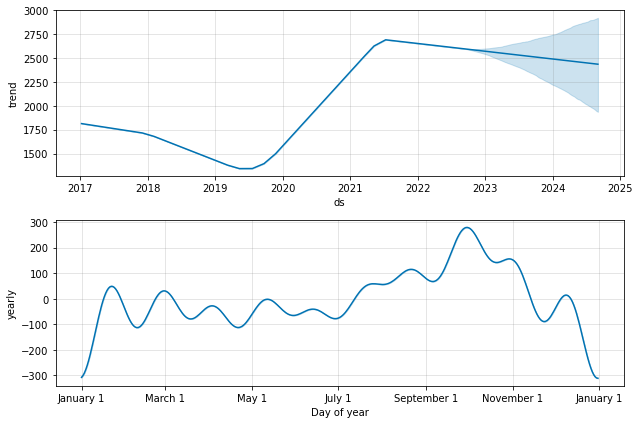

In [13]:
fig2 = m.plot_components(forecast)


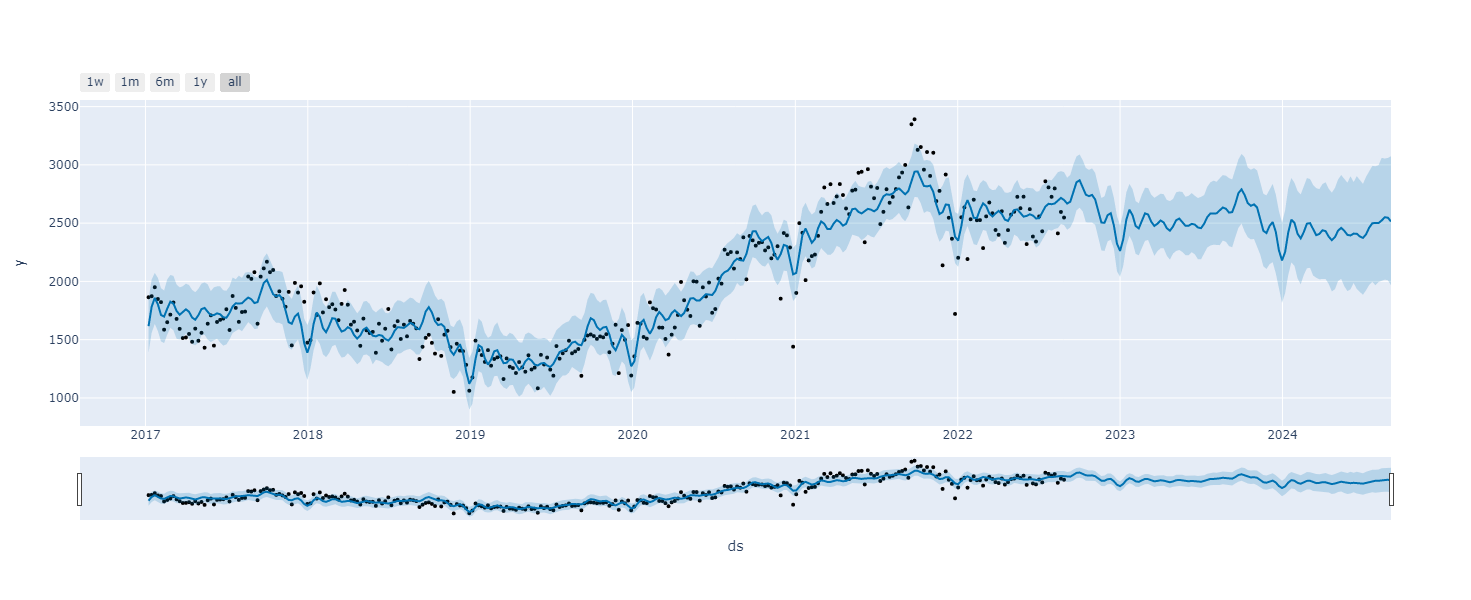

In [14]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

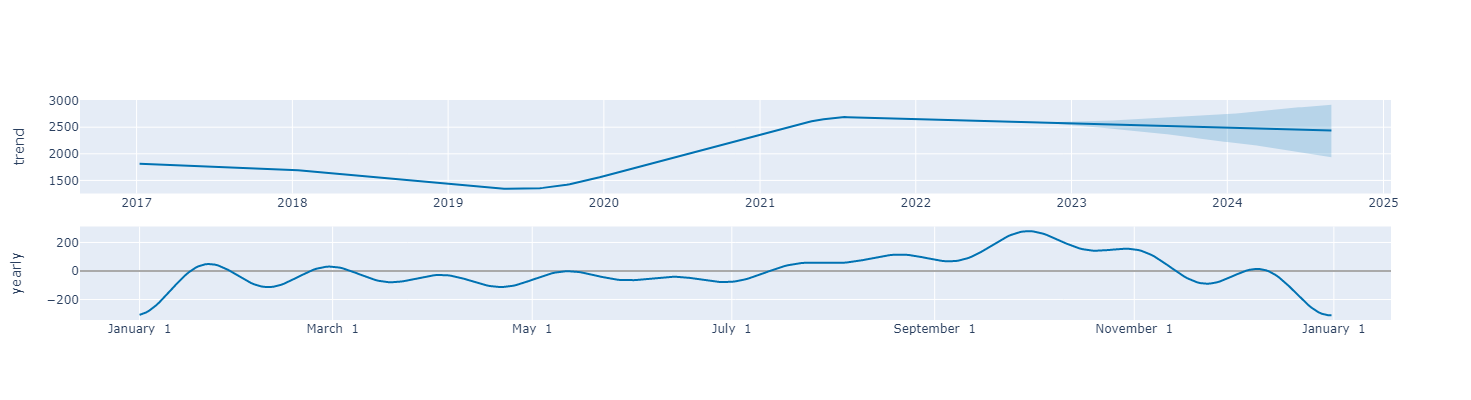

In [15]:
plot_components_plotly(m, forecast)


In [16]:
forecast.tail(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
397 2024-08-18  2439.463302  2014.951622  3054.335584  1956.085917   
398 2024-08-25  2437.904402  2010.024801  3059.519436  1944.162800   
399 2024-09-01  2436.345502  1966.739050  3074.426563  1937.352119   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
397  2910.834923      111.071785            111.071785            111.071785   
398  2916.365187      108.789904            108.789904            108.789904   
399  2922.856571       77.735806             77.735806             77.735806   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
397  111.071785    111.071785    111.071785                   0.0   
398  108.789904    108.789904    108.789904                   0.0   
399   77.735806     77.735806     77.735806                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
397                         0.0                         0.0  2550.535088  
398                         0.0                         0.0  2546.694306  
399                         0.0                         0.0  2514.081307

#### Cross Validation

In [17]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2021-01-17  2413.359483  2231.346673  2585.879624  2417.0 2021-01-15
1 2021-01-24  2479.547650  2307.443878  2653.521800  2011.0 2021-01-15
2 2021-01-31  2416.735574  2236.282436  2603.006930  2180.0 2021-01-15

In [18]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon            mse        rmse         mae      mape     mdape  \
0  2 days   75540.544888  274.846402  221.675779  0.087260  0.074582   
1  9 days  146051.181110  382.166431  289.027001  0.119802  0.085107   
2 16 days  103182.578096  321.220451  267.625343  0.105547  0.090223   

      smape  coverage  
0  0.083436  0.487805  
1  0.109951  0.439024  
2  0.100222  0.390244

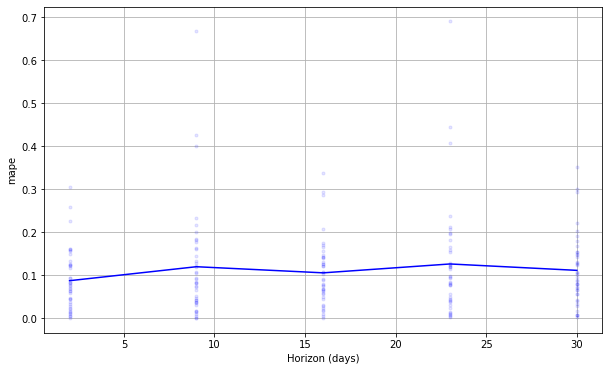

In [19]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [20]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [21]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.10399436950683594 total seconds have elapsed.


## AHT Forecasts

In [22]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 07:00:00    119.0
1 2017-01-02 07:15:00    119.0
2 2017-01-02 07:30:00    960.0

In [23]:
combined_aht = grouped_aht
combined_aht['Actual_AHT'] = grouped_aht['Adj_AHT'] / grouped_cv['Actual_CV']
combined_aht.head(3)

DateTime  Adj_AHT  Actual_AHT
0 2017-01-02 07:00:00    119.0       119.0
1 2017-01-02 07:15:00    119.0       119.0
2 2017-01-02 07:30:00    960.0       320.0

In [24]:
subdaily_adj = grouped_aht[['DateTime','Adj_AHT']]
subdaily_adj['Adj_AHT'] = subdaily_adj['Adj_AHT'].replace(0, np.nan)
weekly_adj = subdaily_adj.resample('W', on='DateTime').sum()
weekly_adj.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_8164\3997668832.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_AHT
DateTime            
2017-01-08  894304.0
2017-01-15  888776.0
2017-01-22  906966.0

In [25]:
subdaily_cv = grouped_cv[['DateTime','Actual_CV']]
weekly_cv = subdaily_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08     1864.0
2017-01-15     1873.0
2017-01-22     1950.0

In [26]:
combined_aht = weekly_adj.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_adj['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
293 2022-08-21  520.257704
294 2022-08-28  528.119309
295 2022-09-04         NaN

In [27]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 07:00:00    777.0
1 2017-01-02 07:15:00    954.0
2 2017-01-02 07:30:00    784.0

In [28]:
combined_for = grouped_for
combined_for['Forecasted_AHT'] = grouped_for['Adj_for'] / grouped_fcv['Forecasted_CV']
combined_for.head(3)

DateTime  Adj_for  Forecasted_AHT
0 2017-01-02 07:00:00    777.0           259.0
1 2017-01-02 07:15:00    954.0           318.0
2 2017-01-02 07:30:00    784.0           392.0

In [29]:
subdaily_for = grouped_for[['DateTime','Adj_for']]
subdaily_for['Adj_for'] = subdaily_for['Adj_for'].replace(0, np.nan)
weekly_adj_for = subdaily_for.resample('W', on='DateTime').sum()
weekly_adj_for.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_8164\494036227.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_for
DateTime            
2017-01-08  806748.0
2017-01-15  803629.0
2017-01-22  828270.0

In [30]:
subdaily_fcv = grouped_fcv[['DateTime','Forecasted_CV']]
weekly_fcv = subdaily_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08         1717.0
2017-01-15         1693.0
2017-01-22         1794.0

In [31]:
combined_for = weekly_adj_for.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_adj_for['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
293 2022-08-21  549.231080
294 2022-08-28  535.692884
295 2022-09-04         NaN

#### Initiate Prophet

In [32]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
397 2024-08-18  576.501952  470.574474  679.093217
398 2024-08-25  576.843403  468.479871  674.571460
399 2024-09-01  578.969938  468.604598  683.195535

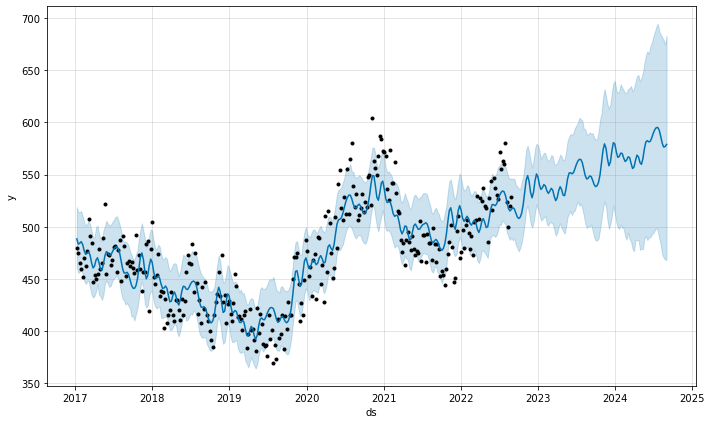

In [35]:
fig1 = m.plot(forecast)

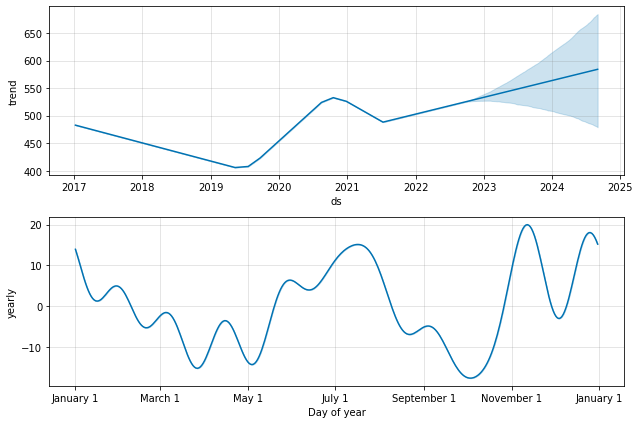

In [36]:
fig2 = m.plot_components(forecast)


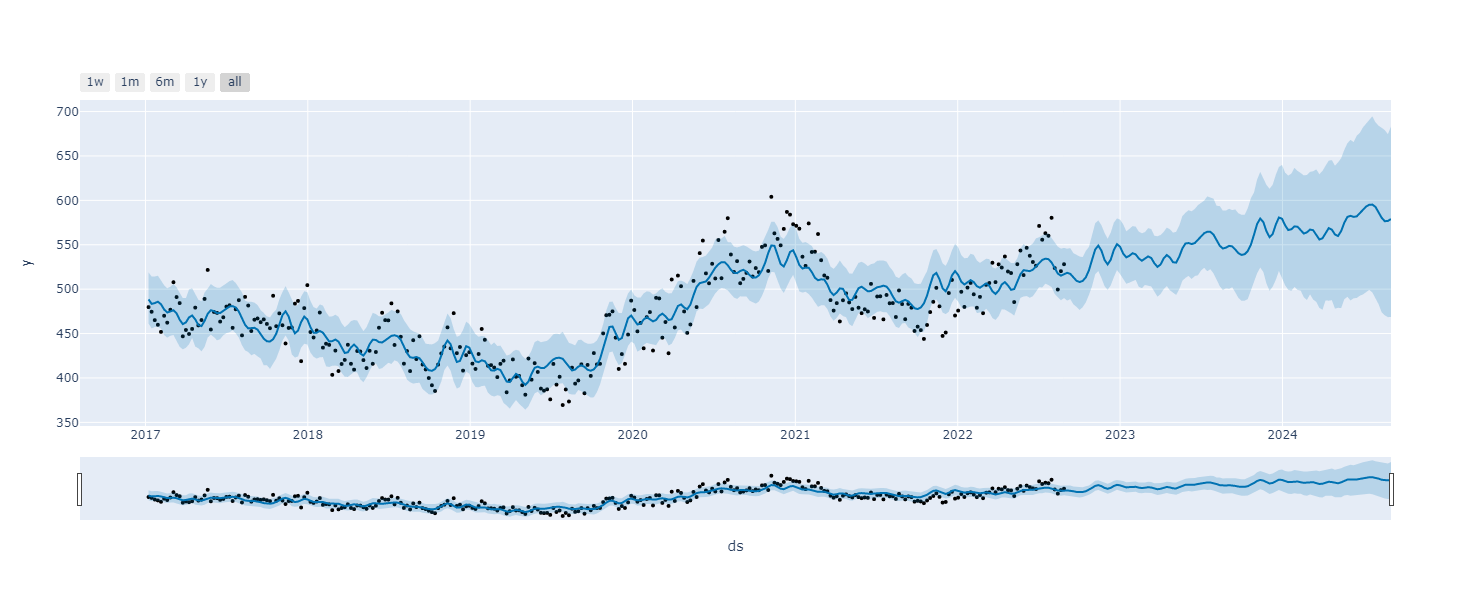

In [37]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

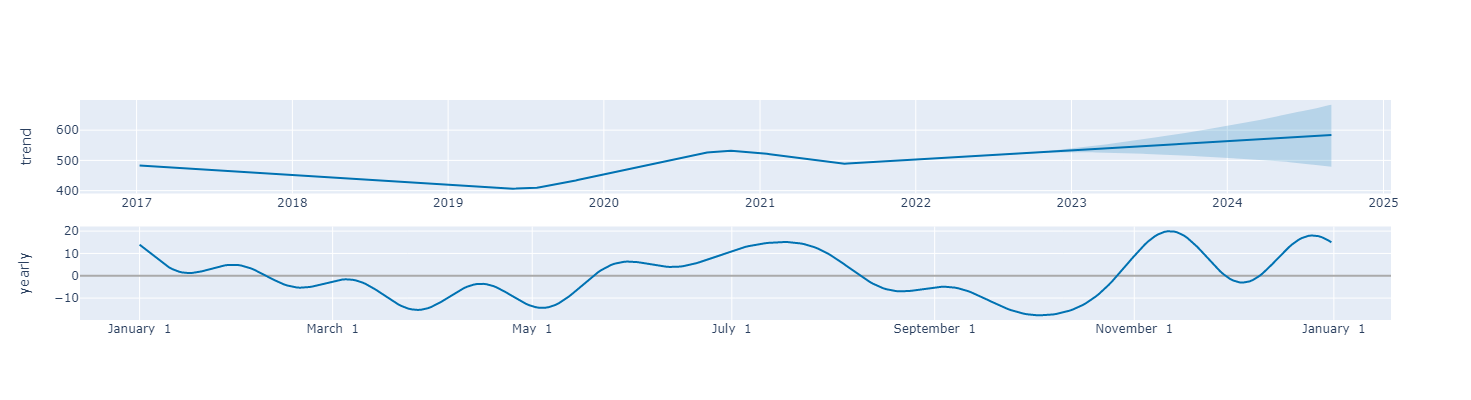

In [38]:
plot_components_plotly(m, forecast)


In [39]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
397 2024-08-18  582.912878  470.574474  679.093217   481.733459   679.912507   
398 2024-08-25  583.497087  468.479871  674.571460   480.708951   682.328157   
399 2024-09-01  584.081295  468.604598  683.195535   479.020552   684.235559   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
397       -6.410927             -6.410927             -6.410927 -6.410927   
398       -6.653683             -6.653683             -6.653683 -6.653683   
399       -5.111357             -5.111357             -5.111357 -5.111357   

     yearly_lower  yearly_upper  multiplicative_terms  \
397     -6.410927     -6.410927                   0.0   
398     -6.653683     -6.653683                   0.0   
399     -5.111357     -5.111357                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
397                         0.0                         0.0  576.501952  
398                         0.0                         0.0  576.843403  
399                         0.0                         0.0  578.969938

#### Cross Validate

In [40]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-17  575.107963  549.515953  597.642166  536.511378 2021-01-15
1 2021-01-24  577.961198  552.316877  602.704833  526.198906 2021-01-15
2 2021-01-31  580.103594  554.240161  605.197318  574.037156 2021-01-15

In [41]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  2020.251249  44.947205  37.655069  0.074394  0.074671  0.074304   
1  9 days  2562.556345  50.621698  44.166758  0.087611  0.085963  0.087693   
2 16 days  2869.568121  53.568350  44.918871  0.089041  0.083939  0.088817   

   coverage  
0  0.414634  
1  0.292683  
2  0.292683

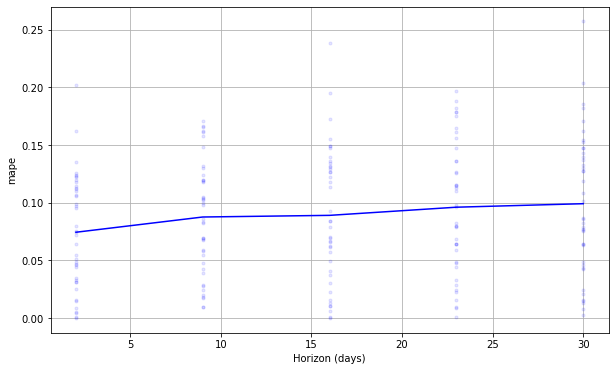

In [42]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [43]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [44]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.11001276969909668 total seconds have elapsed.
